In [1]:
import requests
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import aiosqlite

## Data sources

### CSV

In [2]:
# Sanity for data located in csv file 
path = 'titanic.csv'
df = pd.read_csv(path) 

print(f'{df.shape=}\n')
df.head()

df.shape=(891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### SQLITE

In [3]:
# Create sqlite db from the previously loaded daatframe
db_file = 'titanic.db'
table_name = 'Passengers'

# Establish a connection to the SQLite database
with sqlite3.connect(db_file) as conn:
    # Write the DataFrame to the SQLite database
    df.to_sql(table_name, conn, if_exists='replace', index=False)


In [4]:
# Sanity for data data from the SQLite Passengers table
query = f"SELECT * FROM {table_name}"


with sqlite3.connect(db_file) as conn:
    df = pd.read_sql_query(query, conn)

print(f'{df.shape=}\n')
df.head()

df.shape=(891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


## Swagger Json

In [5]:
# Save swagger documentation to local json file 
swagger_json_url = "http://localhost:8000/openapi.json"
response = requests.get(swagger_json_url)
swagger_json = response.json()

# You can then save the swagger_json to a file
with open("swagger.json", "w") as file:
    file.write(str(swagger_json))

## API methods

### Base URL route

In [13]:
# GET API welcome message
response = requests.get('http://localhost:8000/')
print(response.json())

Welcome to Titanic API!


### Fares histogram route

histogram data:
{'percentiles': [0.0, 7.55, 7.8542, 8.05, 10.5, 14.4542, 21.6792, 27.0, 39.6875, 77.9583], 'counts': [88, 78, 76, 97, 101, 94, 88, 87, 95]}



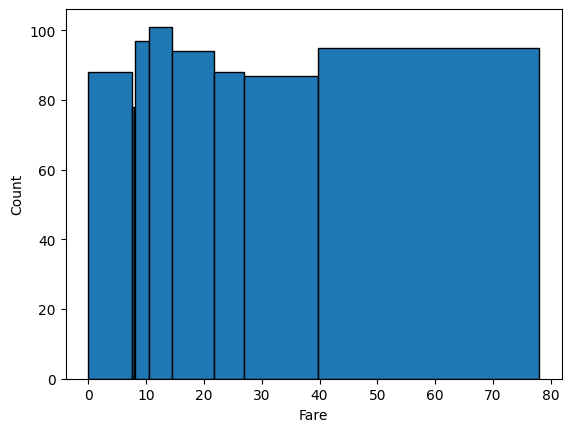

In [14]:
# Get Fare histogram data from server and render it on client side

# To get the fare histogram
response = requests.get('http://localhost:8000/fare_histogram')
data = response.json()
print(f'histogram data:\n{data}\n')

# Create the histogram
plt.bar(data['percentiles'][:-1], data['counts'], width=np.diff(data['percentiles']), edgecolor="black", align="edge")

# Label the axes
plt.xlabel('Fare')
plt.ylabel('Count')

# Show the plot
plt.show()

### Passenger route

#### without attributes

In [15]:
# Get the data for a valid passenger id
passenger_id = 1
response = requests.get(f'http://localhost:8000/passenger/{passenger_id}')
print(f'{response.status_code=}')
response.json()

response.status_code=200


[{'PassengerId': 1,
  'Survived': 0,
  'Pclass': 3,
  'Name': 'Braund, Mr. Owen Harris',
  'Sex': 'male',
  'Age': 22.0,
  'SibSp': 1,
  'Parch': 0,
  'Ticket': 'A/5 21171',
  'Fare': 7.25,
  'Cabin': None,
  'Embarked': 'S'}]

In [16]:
# Try getting data for not existing passenger id
passenger_id = -1
response = requests.get(f'http://localhost:8000/passenger/{passenger_id}')
print(f'{response.status_code=}')
response.json()

response.status_code=404


'Passenger not found for passenger_id=-1'

#### with attributes

In [17]:
# Get 3 valid attributes for valid passenger 
passenger_id = 2
attributes = ['Name', 'Sex', 'Age']

# Send a GET request to the endpoint
response = requests.get(f'http://localhost:8000/passenger/{passenger_id}?attributes={",".join(attributes)}')

# Print the status code and the response body
print("Status code:", response.status_code)
print("Response body:", response.json())

Status code: 200
Response body: [{'Name': 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Sex': 'female', 'Age': 38.0}]


In [18]:
# Try getting invalid attribute along with 3 valid.
# The invalid attribute should be ignored and warning will be shown in the log file. 
passenger_id = 2
attributes = ['Name', 'Sex', 'Age', 'invalid']

# Send a GET request to the endpoint
response = requests.get(f'http://localhost:8000/passenger/{passenger_id}?attributes={",".join(attributes)}')

# Print the status code and the response body
print("Status code:", response.status_code)
print("Response body:", response.json())

Status code: 200
Response body: [{'Name': 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)', 'Sex': 'female', 'Age': 38.0}]


### Passengers route

In [19]:
# Get all passengers data
response = requests.get('http://localhost:8000/passengers')
print(f'total passengers = {len(response.json())}')
print('First 2 passengers data:')
response.json()[:2]

total passengers = 891
First 2 passengers data:


[{'PassengerId': 1,
  'Survived': 0,
  'Pclass': 3,
  'Name': 'Braund, Mr. Owen Harris',
  'Sex': 'male',
  'Age': 22.0,
  'SibSp': 1,
  'Parch': 0,
  'Ticket': 'A/5 21171',
  'Fare': 7.25,
  'Cabin': None,
  'Embarked': 'S'},
 {'PassengerId': 2,
  'Survived': 1,
  'Pclass': 1,
  'Name': 'Cumings, Mrs. John Bradley (Florence Briggs Thayer)',
  'Sex': 'female',
  'Age': 38.0,
  'SibSp': 1,
  'Parch': 0,
  'Ticket': 'PC 17599',
  'Fare': 71.2833,
  'Cabin': 'C85',
  'Embarked': 'C'}]

## invalid Data scource

In [21]:
# Sending a request when the data scouce is not valid
response = requests.get('http://localhost:8000/passengers')
vars(response)

{'_content': b'"data source issue"',
 '_content_consumed': True,
 '_next': None,
 'status_code': 500,
 'headers': {'date': 'Wed, 19 Jul 2023 14:17:33 GMT', 'server': 'uvicorn', 'content-length': '19', 'content-type': 'application/json'},
 'raw': <urllib3.response.HTTPResponse at 0x1a83ad3ac20>,
 'url': 'http://localhost:8000/passengers',
 'encoding': 'utf-8',
 'history': [],
 'reason': 'Internal Server Error',
 'cookies': <RequestsCookieJar[]>,
 'elapsed': datetime.timedelta(seconds=2, microseconds=33143),
 'request': <PreparedRequest [GET]>,
 'connection': <requests.adapters.HTTPAdapter at 0x1a83ae02e90>}